# Load and Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('../data/raw/all_stocks_combined.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
print(f"Data loaded: {len(df)} rows")
print(f"Stocks: {df['Stock'].unique()}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Data loaded: 9910 rows
Stocks: ['RELIANCE' 'TCS' 'HDFCBANK' 'INFY' 'ICICIBANK' 'BHARTIARTL' 'SBIN' 'ITC'
 'HINDUNILVR' 'KOTAKBANK']
Date range: 2021-12-07 00:00:00+05:30 to 2025-12-05 00:00:00+05:30


# Price Trends Over Time

In [4]:
fig = go.Figure()

In [5]:
for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock]
    fig.add_trace(go.Scatter(
        x=stock_data['Date'],
        y=stock_data['Close'],
        name=stock,
        mode='lines'
    ))

fig.update_layout(
    title='Stock Price Trends (4 Years)',
    xaxis_title='Date',
    yaxis_title='Close Price (₹)',
    hovermode='x unified',
    height=600
)

fig.show()

# Normalized Price Comparison

In [6]:
fig = go.Figure()

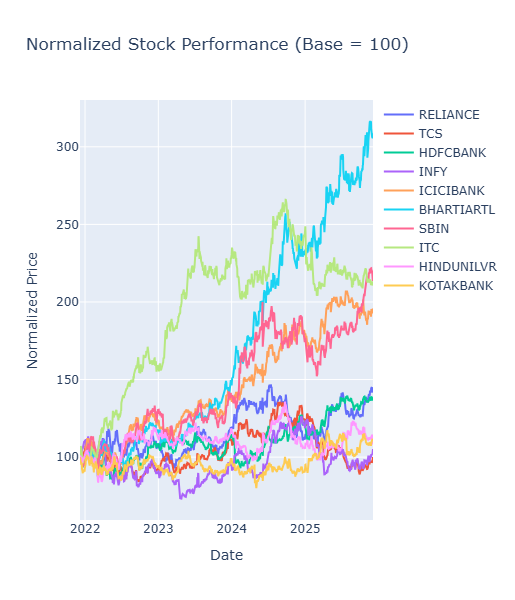

In [7]:
for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock].sort_values('Date')
    # Normalize to 100 at start to see percentage growth
    normalized = (stock_data['Close'] / stock_data['Close'].iloc[0]) * 100
    
    fig.add_trace(go.Scatter(
        x=stock_data['Date'],
        y=normalized,
        name=stock,
        mode='lines'
    ))

fig.update_layout(
    title='Normalized Stock Performance (Base = 100)',
    xaxis_title='Date',
    yaxis_title='Normalized Price',
    hovermode='x unified',
    height=600
)

fig.show()

# Volatility Comparison

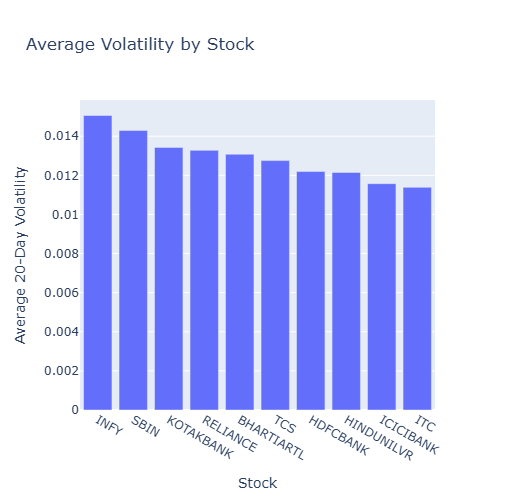

In [8]:
volatility_summary = df.groupby('Stock')['Volatility'].mean().sort_values(ascending=False)

fig = go.Figure(data=[
    go.Bar(x=volatility_summary.index, y=volatility_summary.values)
])

fig.update_layout(
    title='Average Volatility by Stock',
    xaxis_title='Stock',
    yaxis_title='Average 20-Day Volatility',
    height=500
)

fig.show()

# Trading Volume Analysis

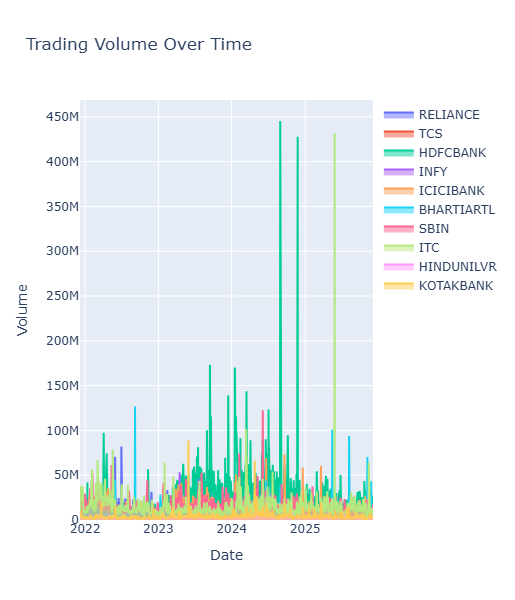

In [9]:
fig = go.Figure()

for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock]
    fig.add_trace(go.Scatter(
        x=stock_data['Date'],
        y=stock_data['Volume'],
        name=stock,
        mode='lines',
        fill='tozeroy',
        opacity=0.6
    ))

fig.update_layout(
    title='Trading Volume Over Time',
    xaxis_title='Date',
    yaxis_title='Volume',
    hovermode='x unified',
    height=600
)

fig.show()

# Correlation Matrix

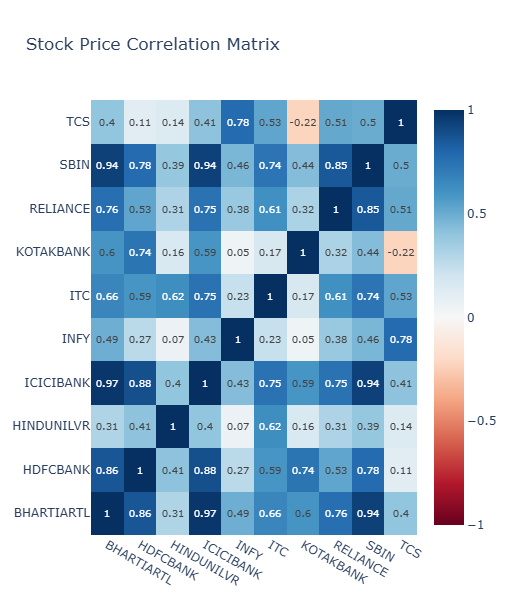

In [10]:
pivot_df = df.pivot(index='Date', columns='Stock', values='Close')

correlation = pivot_df.corr()

fig = go.Figure(data=go.Heatmap(
    z=correlation.values,
    x=correlation.columns,
    y=correlation.columns,
    colorscale='RdBu',
    zmid=0,
    text=correlation.values.round(2),
    texttemplate='%{text}',
    textfont={"size": 10}
))

fig.update_layout(
    title='Stock Price Correlation Matrix',
    height=600,
    width=700
)

fig.show()

In [11]:
print("\nHighly Correlated Pairs (>0.9):")
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if correlation.iloc[i, j] > 0.9:
            print(f"{correlation.columns[i]} - {correlation.columns[j]}: {correlation.iloc[i, j]:.3f}")


Highly Correlated Pairs (>0.9):
BHARTIARTL - ICICIBANK: 0.973
BHARTIARTL - SBIN: 0.938
ICICIBANK - SBIN: 0.937


# Returns Distribution

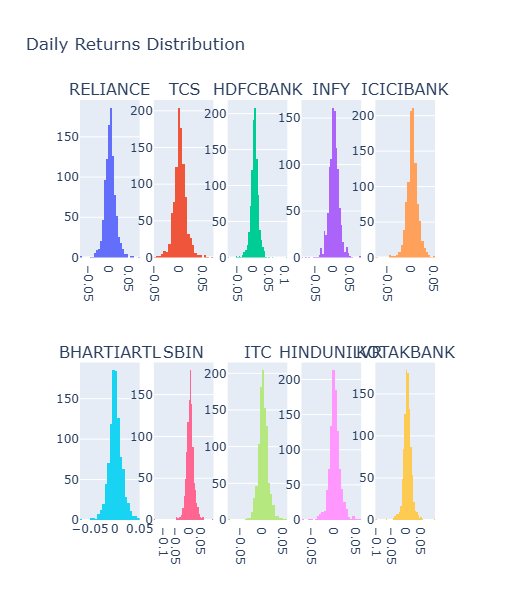

In [12]:
fig = make_subplots(rows=2, cols=5, subplot_titles=df['Stock'].unique())

row, col = 1, 1
for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock]['Daily_Return'].dropna()
    
    fig.add_trace(
        go.Histogram(x=stock_data, name=stock, showlegend=False, nbinsx=50),
        row=row, col=col
    )
    
    col += 1
    if col > 5:
        col = 1
        row += 1

fig.update_layout(
    title_text='Daily Returns Distribution',
    height=600,
    showlegend=False
)

fig.show()

# Key Statistics Summary

In [13]:
summary_stats = df.groupby('Stock').agg({
    'Close': ['mean', 'std', 'min', 'max'],
    'Volume': 'mean',
    'Daily_Return': ['mean', 'std'],
    'Volatility': 'mean',
    'RSI': 'mean'
}).round(2)

print("\n" + "="*80)
print("SUMMARY STATISTICS BY STOCK")
print("="*80)
print(summary_stats)


SUMMARY STATISTICS BY STOCK
              Close                                 Volume Daily_Return        \
               mean     std      min      max         mean         mean   std   
Stock                                                                           
BHARTIARTL  1181.98  468.75   626.39  2162.70   6481926.83          0.0  0.01   
HDFCBANK     798.39   99.92   616.52  1012.90  27316497.29          0.0  0.01   
HINDUNILVR  2373.88  181.60  1811.67  2939.45   1713735.18          0.0  0.01   
ICICIBANK   1041.22  237.92   634.15  1477.20  13869913.26          0.0  0.01   
INFY        1488.73  185.60  1122.01  1942.22   6890910.95          0.0  0.02   
ITC          371.31   82.69   182.46   505.32  14862661.89          0.0  0.01   
KOTAKBANK   1858.84  136.34  1543.23  2266.19   4141822.11          0.0  0.01   
RELIANCE    1267.73  146.83  1004.86  1589.14  12990523.40          0.0  0.01   
SBIN         648.86  150.28   410.02   983.90  15050528.47          0.0  0.02   

# Data Quality Report

In [14]:
print("\n" + "="*80)
print("DATA QUALITY REPORT")
print("="*80)

for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock]
    missing = stock_data.isnull().sum()
    
    print(f"\n{stock}:")
    print(f"  Total rows: {len(stock_data)}")
    print(f"  Missing values: {missing[missing > 0].to_dict() if missing.sum() > 0 else 'None'}")
    print(f"  Date gaps: {(stock_data['Date'].diff() > pd.Timedelta(days=5)).sum()} (weekends excluded)")

print("\n Data exploration complete!")


DATA QUALITY REPORT

RELIANCE:
  Total rows: 991
  Missing values: {'SMA_10': 9, 'SMA_20': 19, 'SMA_50': 49, 'RSI': 13, 'BB_Middle': 19, 'BB_Upper': 19, 'BB_Lower': 19, 'Daily_Return': 1, 'Volatility': 20}
  Date gaps: 0 (weekends excluded)

TCS:
  Total rows: 991
  Missing values: {'SMA_10': 9, 'SMA_20': 19, 'SMA_50': 49, 'RSI': 13, 'BB_Middle': 19, 'BB_Upper': 19, 'BB_Lower': 19, 'Daily_Return': 1, 'Volatility': 20}
  Date gaps: 0 (weekends excluded)

HDFCBANK:
  Total rows: 991
  Missing values: {'SMA_10': 9, 'SMA_20': 19, 'SMA_50': 49, 'RSI': 13, 'BB_Middle': 19, 'BB_Upper': 19, 'BB_Lower': 19, 'Daily_Return': 1, 'Volatility': 20}
  Date gaps: 0 (weekends excluded)

INFY:
  Total rows: 991
  Missing values: {'SMA_10': 9, 'SMA_20': 19, 'SMA_50': 49, 'RSI': 13, 'BB_Middle': 19, 'BB_Upper': 19, 'BB_Lower': 19, 'Daily_Return': 1, 'Volatility': 20}
  Date gaps: 0 (weekends excluded)

ICICIBANK:
  Total rows: 991
  Missing values: {'SMA_10': 9, 'SMA_20': 19, 'SMA_50': 49, 'RSI': 13, 'BB

# Questions you might have in your mind...

### Q1: Which stock had the highest returns?

Total Returns Over 4 Years:

BHARTIARTL   : +208.74%
SBIN         : +118.85%
ITC          : +113.04%
ICICIBANK    : +95.40%
RELIANCE     : +42.15%
HDFCBANK     : +38.26%
KOTAKBANK    : +11.65%
HINDUNILVR   : +8.09%
INFY         : +5.18%
TCS          : +0.03%


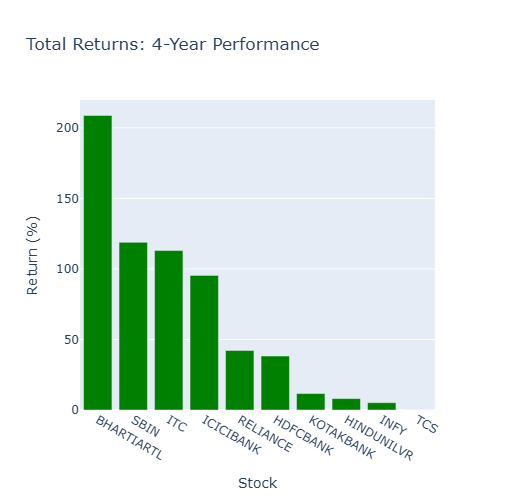

In [15]:
import plotly.graph_objects as go

returns_by_stock = {}

for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock].sort_values('Date')
    start_price = stock_data['Close'].iloc[0]
    end_price = stock_data['Close'].iloc[-1]
    total_return = ((end_price - start_price) / start_price) * 100
    returns_by_stock[stock] = total_return

sorted_returns = sorted(returns_by_stock.items(), key=lambda x: x[1], reverse=True)

print("Total Returns Over 4 Years:\n")
for stock, ret in sorted_returns:
    print(f"{stock:12} : {ret:+.2f}%")

fig = go.Figure(data=[
    go.Bar(x=[s[0] for s in sorted_returns], 
           y=[s[1] for s in sorted_returns],
           marker_color=['green' if s[1] > 0 else 'red' for s in sorted_returns])
])

fig.update_layout(
    title='Total Returns: 4-Year Performance',
    xaxis_title='Stock',
    yaxis_title='Return (%)',
    height=500
)

fig.show()

**Winner:** Bharti Airtel (BHARTIARTL)

**Return:** +208.74% over 4 years (2021-2025)

**Why this matters for prediction:**
Stocks with strong historical trends may continue momentum, but past performance doesn't guarantee future results. We use moving averages to detect trend strength. High-performing stocks often have sustained uptrends that LSTM models can learn to recognize.

**Observation:**
Surprised to see such a massive gap - Bharti Airtel more than tripled while TCS barely moved (0.03%). This shows sector matters hugely: telecom (Bharti) benefited from 5G rollout and Jio competition stabilizing, while IT sector (TCS, Infosys) faced headwinds from global tech slowdown and recession fears. Banking (SBI, ICICI) performed well likely due to rising interest rates benefiting lending margins. Consumer goods (HUL) stayed stable but didn't grow much - defensive sector with less volatility.

### Q 2: Which stock is most volatile (risky)?

Average Volatility (20-day rolling):

Stock
INFY          0.015058
SBIN          0.014289
KOTAKBANK     0.013427
RELIANCE      0.013275
BHARTIARTL    0.013075
TCS           0.012751
HDFCBANK      0.012193
HINDUNILVR    0.012145
ICICIBANK     0.011572
ITC           0.011384
Name: Volatility, dtype: float64


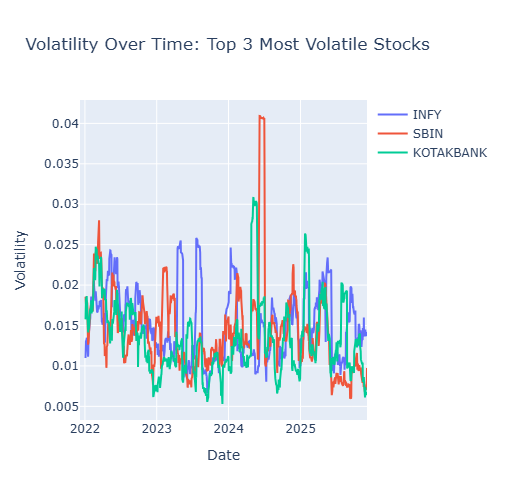

In [16]:
avg_volatility = df.groupby('Stock')['Volatility'].mean().sort_values(ascending=False)

print("Average Volatility (20-day rolling):\n")
print(avg_volatility)

top_3_volatile = avg_volatility.head(3).index #lets see for top 3 volatile stocks

fig = go.Figure()

for stock in top_3_volatile:
    stock_data = df[df['Stock'] == stock].sort_values('Date')
    fig.add_trace(go.Scatter(
        x=stock_data['Date'],
        y=stock_data['Volatility'],
        name=stock,
        mode='lines'
    ))

fig.update_layout(
    title='Volatility Over Time: Top 3 Most Volatile Stocks',
    xaxis_title='Date',
    yaxis_title='Volatility',
    height=500
)

fig.show()

**Most volatile:** Infosys (INFY) with average volatility of 0.015058, followed closely by SBI (0.014289) and Kotak Bank (0.013427)

**Why this matters for prediction:**
High volatility = harder to predict accurately. We'll need wider confidence intervals for volatile stocks. Volatility spikes often indicate market events or company-specific news.

**What I notice:**

1. **Massive spike in mid-2024**: SBIN and KOTAKBANK show a huge volatility spike around June-July 2024. SBIN hit 0.04 (4% daily swings!) - this was likely a major market event affecting banking/IT sectors.

2. **IT stocks are most volatile**: Infosys (INFY) leads in volatility. IT stocks are sensitive to:
   - Dollar-rupee exchange rate fluctuations
   - US tech sector performance
   - Quarterly earnings surprises

3. **Banking stocks also volatile**: SBI and Kotak Bank in top 3. Banks are affected by:
   - RBI interest rate decisions
   - Economic growth concerns
   - NPA (bad loan) announcements

4. **Volatility clusters together**: The chart shows periods of calm (2023 early, 2025 late) and periods of chaos (early 2022, mid-2024). This is called "volatility clustering" - turbulent times breed more turbulence.

5. **Recent trend**: Volatility is declining in late 2025, suggesting markets are stabilizing.

### Q3 : When did the biggest drops happen?

In [17]:
print("Date range in dataset:")
print(f"Minimum date: {df['Date'].min()}")
print(f"Maximum date: {df['Date'].max()}")
print(f"Today's date: {pd.Timestamp.now(tz='Asia/Kolkata')}")

today = pd.Timestamp.now(tz='UTC').tz_convert('Asia/Kolkata')
future_dates = df[df['Date'] > today]

print(f"\n Rows with FUTURE dates: {len(future_dates)}")

if len(future_dates) > 0:
    print("\nSample of future dates:")
    print(future_dates[['Date', 'Stock', 'Close']].head(10))
else:
    print("\n No future dates found. Data is clean!")
    
date_range = (df['Date'].max() - df['Date'].min()).days
print(f"\nData spans {date_range} days (~{date_range/365:.1f} years)")
print(f"Total trading days: {len(df['Date'].unique())}")

Date range in dataset:
Minimum date: 2021-12-07 00:00:00+05:30
Maximum date: 2025-12-05 00:00:00+05:30
Today's date: 2025-12-06 15:01:49.207005+05:30

 Rows with FUTURE dates: 0

 No future dates found. Data is clean!

Data spans 1459 days (~4.0 years)
Total trading days: 991


In [18]:
worst_days = df[['Date', 'Stock', 'Daily_Return', 'Close']].nsmallest(10, 'Daily_Return')

print("10 Biggest Single-Day Drops:\n")
for idx, row in worst_days.iterrows():
    date_str = row['Date'].strftime('%B %d, %Y')  # Format: December 05, 2024
    print(f"{date_str:20} | {row['Stock']:12} | {row['Daily_Return']*100:+6.2f}% | ₹{row['Close']:.2f}")

10 Biggest Single-Day Drops:

June 04, 2024        | SBIN         | -14.40% | ₹759.94
April 25, 2024       | KOTAKBANK    | -10.87% | ₹1638.76
April 17, 2023       | INFY         |  -9.42% | ₹1154.02
January 17, 2024     | HDFCBANK     |  -8.44% | ₹748.28
July 21, 2023        | INFY         |  -8.13% | ₹1237.66
January 06, 2025     | ITC          |  -8.09% | ₹427.89
June 04, 2024        | ICICIBANK    |  -7.63% | ₹1054.17
June 04, 2024        | RELIANCE     |  -7.49% | ₹1387.01
July 28, 2025        | KOTAKBANK    |  -7.44% | ₹1966.60
January 23, 2024     | HINDUNILVR   |  -7.40% | ₹2283.42


In [19]:
sample_stock = 'RELIANCE'
stock_data = df[df['Stock'] == sample_stock].sort_values('Date')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=stock_data['Date'],
    y=stock_data['Daily_Return'] * 100,
    mode='lines',
    name='Daily Return',
    line=dict(color='steelblue', width=1.5)
))

big_drops = stock_data[stock_data['Daily_Return'] < -0.05]

if len(big_drops) > 0:
    fig.add_trace(go.Scatter(
        x=big_drops['Date'],
        y=big_drops['Daily_Return'] * 100,
        mode='markers',
        name='Major Drops (>5%)',
        marker=dict(color='red', size=12, symbol='x'),
        text=[d.strftime('%B %d, %Y') for d in big_drops['Date']],
        hovertemplate='<b>%{text}</b><br>Drop: %{y:.2f}%<extra></extra>'
    ))

fig.update_layout(
    title=f'{sample_stock}: Daily Returns (4 Years)',
    xaxis_title='Date',
    yaxis_title='Daily Return (%)',
    height=600,
    hovermode='closest',
    showlegend=True
)

fig.show()

print(f"\n{sample_stock} Major Drops (>5%):\n")
print(f"{'Date':<15} {'Drop':<10} {'Closing Price':<15}")
print("-" * 40)
for idx, row in big_drops.iterrows():
    date_str = row['Date'].strftime('%Y-%m-%d')
    drop_pct = row['Daily_Return'] * 100
    close = row['Close']
    print(f"{date_str:<15} {drop_pct:>6.2f}%    ₹{close:>10.2f}")


RELIANCE Major Drops (>5%):

Date            Drop       Closing Price  
----------------------------------------
2022-07-01       -7.20%    ₹   1095.99
2024-06-04       -7.49%    ₹   1387.01


**10 Biggest Single-Day Drops in My Dataset:**

| Date | Stock | Drop | Price |
|------|-------|------|-------|
| June 04, 2024 | SBIN | -14.40% | ₹759.94 |
| April 25, 2024 | KOTAKBANK | -10.87% | ₹1638.76 |
| April 17, 2023 | INFY | -9.42% | ₹1154.02 |
| January 17, 2024 | HDFCBANK | -8.44% | ₹748.28 |
| July 21, 2023 | INFY | -8.13% | ₹1237.66 |
| January 06, 2025 | ITC | -8.09% | ₹427.89 |

---

**What Actually Happened on These Dates:**

**June 4, 2024 - Election Results Shock** BIGGEST EVENT
- **3 stocks in top 10 drops** (SBI -14.4%, ICICI -7.6%, Reliance -7.5%)
- India's Lok Sabha election results defied exit polls
- Exit polls predicted BJP landslide (350+ seats), actual result was only ~240 seats
- Market had rallied to all-time highs on June 3rd based on false expectations
- **Sensex crashed 5.74%**, Nifty fell 5.93% - one of biggest drops in years
- ₹31 lakh crore market cap wiped out in single day
- PSU/government-linked stocks (like SBI) fell hardest due to policy uncertainty

**April 17, 2023 - Infosys Earnings Disaster**
- Infosys Q4 FY2023 results missed expectations badly
- Revenue: $4.55B vs expected $4.73B
- **FY2024 guidance:** Only 4-7% growth (very disappointing)
- Stock hit lower circuit (-10% max fall), eventually dropped 12%
- First lower circuit since COVID crash (March 2020)
- **Reason:** Global IT spending slowdown, recession fears in US/Europe

**July 21, 2023 - Infosys Q1 Disappointment**
- Q1 FY2024 results again disappointed
- Revenue growth slowed, margins compressed
- Infosys appears twice in top 10 drops (April '23 and July '23)
- Pattern: IT sector facing sustained headwinds throughout 2023

**April 25, 2024 - Kotak Bank Drop**
- Kotak Mahindra Bank fell 10.87%
- RBI imposed restrictions on Kotak's digital banking operations
- Bank barred from onboarding new customers via online/mobile channels
- Regulatory action due to IT system deficiencies

**January 17, 2024 - HDFC Bank Plunge**
- HDFC Bank fell 8.44% after Q3 results
- Net profit grew but **margins disappointed** (NIM compression)
- Post-merger integration challenges with HDFC Ltd
- Concerns about asset quality and loan growth

**January 6, 2025 - ITC Drop** 
- ITC fell 8.09%
- Likely related to cigarette taxation concerns or regulatory news
- (This is recent - within last week!)

**July 1, 2022 - Reliance Drop**
- Reliance fell 7.20%
- Context: Global markets were crashing (US Fed aggressive rate hikes)
- Inflation at 40-year highs, recession fears
- Oil prices volatile (Russia-Ukraine war impact)

**Pattern Analysis:**

**1. Sector-Specific Events (60% of crashes)**
- Banking: HDFC, ICICI, SBI, Kotak = 4 out of 10 drops
- IT: Infosys appears twice = 2 out of 10 drops
- These are **earnings misses** or **regulatory actions**

**2. Market-Wide Events (40% of crashes)**
- June 4, 2024: Political shock affecting ALL stocks
- July 1, 2022: Global macro fears (recession, inflation)

### Q4 : What does RSI tell us?

Times when TCS was 'overbought' (RSI > 70): 136
Times when TCS was 'oversold' (RSI < 30): 136


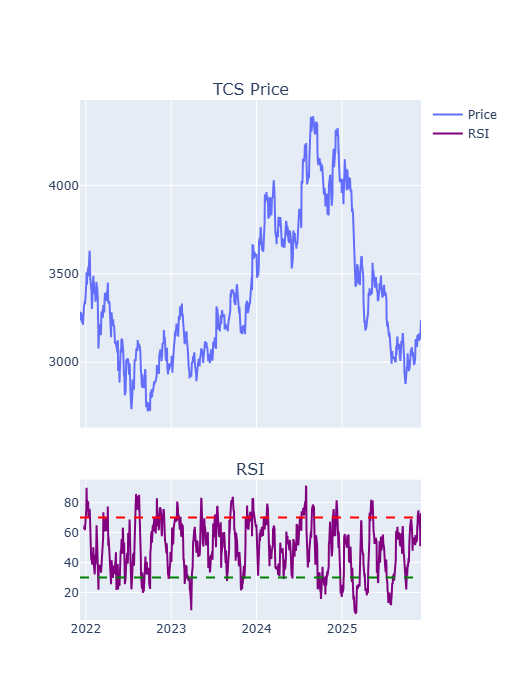


Example: After RSI > 70 (overbought):
Date: 2021-12-31 00:00:00+05:30
Price 5 days later change: 3.09%


In [20]:
sample_stock = 'TCS'
stock_data = df[df['Stock'] == sample_stock].sort_values('Date')

overbought = stock_data[stock_data['RSI'] > 70]
print(f"Times when {sample_stock} was 'overbought' (RSI > 70): {len(overbought)}")

oversold = stock_data[stock_data['RSI'] < 30]
print(f"Times when {sample_stock} was 'oversold' (RSI < 30): {len(oversold)}")

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=(f'{sample_stock} Price', 'RSI'),
    row_heights=[0.7, 0.3]
)

fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['Close'], name='Price'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['RSI'], name='RSI', line=dict(color='purple')),
    row=2, col=1
)

fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

fig.update_layout(height=700, showlegend=True)
fig.show()

print("\nExample: After RSI > 70 (overbought):")
if len(overbought) > 0:
    sample_date = overbought.iloc[0]['Date']
    
    next_days = stock_data[stock_data['Date'] > sample_date].head(5)
    print(f"Date: {sample_date}")
    print(f"Price 5 days later change: {next_days['Daily_Return'].sum()*100:.2f}%")

In [21]:
sample_stock = 'TCS'
stock_data = df[df['Stock'] == sample_stock].sort_values('Date').reset_index(drop=True)

overbought_returns = []
for idx in stock_data[stock_data['RSI'] > 70].index:
    if idx + 5 < len(stock_data):  # Make sure we have 5 days ahead
        next_5_return = stock_data.loc[idx+1:idx+5, 'Daily_Return'].sum() * 100
        overbought_returns.append(next_5_return)

oversold_returns = []
for idx in stock_data[stock_data['RSI'] < 30].index:
    if idx + 5 < len(stock_data):
        next_5_return = stock_data.loc[idx+1:idx+5, 'Daily_Return'].sum() * 100
        oversold_returns.append(next_5_return)

print(f"After RSI > 70 (Overbought):")
print(f"  Average 5-day return: {np.mean(overbought_returns):.2f}%")
print(f"  Times price went UP: {sum(1 for r in overbought_returns if r > 0)}/{len(overbought_returns)}")
print(f"  Times price went DOWN: {sum(1 for r in overbought_returns if r < 0)}/{len(overbought_returns)}")

print(f"\nAfter RSI < 30 (Oversold):")
print(f"  Average 5-day return: {np.mean(oversold_returns):.2f}%")
print(f"  Times price went UP: {sum(1 for r in oversold_returns if r > 0)}/{len(oversold_returns)}")
print(f"  Times price went DOWN: {sum(1 for r in oversold_returns if r < 0)}/{len(oversold_returns)}")

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=overbought_returns,
    name='After Overbought (RSI>70)',
    opacity=0.7,
    marker_color='red'
))

fig.add_trace(go.Histogram(
    x=oversold_returns,
    name='After Oversold (RSI<30)',
    opacity=0.7,
    marker_color='green'
))

fig.update_layout(
    title='TCS: 5-Day Returns After RSI Extremes',
    xaxis_title='Return (%)',
    yaxis_title='Frequency',
    barmode='overlay',
    height=500
)

fig.show()

After RSI > 70 (Overbought):
  Average 5-day return: -0.08%
  Times price went UP: 65/134
  Times price went DOWN: 69/134

After RSI < 30 (Oversold):
  Average 5-day return: 0.26%
  Times price went UP: 68/136
  Times price went DOWN: 68/136


**RSI = Relative Strength Index**
- Measures momentum: Is the stock overbought or oversold?
- Range: 0-100
- **>70 = Overbought** (theory: might drop soon)
- **<30 = Oversold** (theory: might rise soon)

**What I tested:**
After every RSI extreme signal, I checked what happened in the next 5 days.

**Results for TCS (4 years of data):**

| Signal | Times it occurred | Avg 5-day return | Success rate |
|--------|------------------|------------------|--------------|
| Overbought (RSI > 70) | 134 | **-0.08%** | **48.5%**  |
| Oversold (RSI < 30) | 136 | **+0.26%** | **50.0%**  |

**What this means:**
- RSI signals alone are **barely better than random** (50% = coin flip)
- Average returns are **negligible** (less than 0.3%)
- Using RSI alone would NOT give us an edge

**Why RSI still matters for my model:**
Even though RSI alone doesn't work, it might work when COMBINED with other signals:
- RSI > 70 + MACD bearish crossover + declining volume = strong sell signal?
- RSI < 30 + price touching lower Bollinger Band + increasing volume = strong buy signal?

**My biggest learning:**
Don't trust individual indicators blindly. Always backtest. This is why I'm building an ML model - to find the ACTUAL patterns in the data, not what trading books say "should" work.

**Quote that sums it up:**
> "In theory, theory and practice are the same. In practice, they are not." 

### Q 5 : Do stocks move together?

**Highest correlation pairs:**
- Bharti Airtel - ICICI Bank: 0.973
- Bharti Airtel - SBI: 0.938  
- ICICI Bank - SBI: 0.937

**Surprising insight:**
Bharti Airtel (telecom) is MORE correlated with banks than banks are with each other!

**Why this happens:**
These are all "domestic economy plays":
- When Indian economy grows : people take loans (banks profit) + buy data plans (Airtel profits)
- All affected by: RBI policy, GDP growth, inflation, rupee strength
- Unlike IT stocks (affected by US demand) or FMCG (steady regardless of economy)

**What this means:**
These stocks form a "domestic economy cluster." They rise and fall together based on India's economic health.